In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,Column,join
from astropy.io import fits
from astropy.constants import c
from astropy.time import Time
import astropy.units as u
import yaml
import os
from glob import glob
from tqdm.notebook import tqdm

In [2]:
SD_DIR = '/Users/mbedell/python/stellardiff/'
DATA_DIR = '/Users/mbedell/Documents/Research/tauceti/solartwins/'

In [3]:
import sys
sys.path.append(SD_DIR)

In [4]:
import stellardiff as sd
sd

<module 'stellardiff' from '/Users/mbedell/python/stellardiff/stellardiff/__init__.py'>

In [5]:
# load in Na,Mg lines only
transitions = sd.linelist.LineList.read(SD_DIR+"sun_linelist.moog")
mask = (transitions['species'] >= 11.0) & (transitions['species'] < 13.0)
transitions = transitions[mask]

In [6]:
# set up profile
with open(SD_DIR+"sun_settings.yaml", "r") as fp:
    profile_settings = yaml.load(fp, Loader=yaml.Loader)

In [7]:
# just copying the script here
transitions["equivalent_width"] = np.nan * np.ones(len(transitions))
transitions["equivalent_width_err_pos"] = np.nan * np.ones(len(transitions))
transitions["equivalent_width_err_neg"] = np.nan * np.ones(len(transitions))

quality_constraints = dict(
  #abundance=[-10, 10],
  #abundance_uncertainty=[0, 1],
  #equivalent_width=[1, 1000],
  equivalent_width=[0.001, 1000],
  #equivalent_width_percentage_uncertainty=[0, 25],
  #equivalent_width_uncertainty=[0, 1000],
  #reduced_equivalent_width=[-10, -3],
)

overwrite_kwds = dict()#profile="gaussian")

In [8]:
input_spectra_path = glob(DATA_DIR+'*.fits')
all_stars = []
MAKE_FIGURES = False

In [9]:
for input_spectrum in tqdm(input_spectra_path):
    star = os.path.basename(input_spectrum).split("_n.fits")[0]
    #star = star.replace('hip','HIP')
    all_stars.append(star)
    
    # read the spectrum:
    # TODO: check whether I need to sort wavelengths
    # TODO: switch to a less stupid method of combining orders
    with fits.open(input_spectrum) as hdus:
        flux = np.copy(hdus[0].data)
        wave = hdus[0].header['CRVAL1'] + np.arange(len(flux)) * hdus[0].header['CDELT1']
        ivars = 1./flux # HACK
            
    spectrum = sd.spectrum.Spectrum1D(wave,flux,ivars)
    
    models = []
    indices = []

    for i, settings in enumerate(profile_settings):
        # Skip bad lines.
        if not settings["metadata"]["is_acceptable"]:
            continue

        # Create a transitions mask.
        tm = np.in1d(transitions["hash"], settings["transition_hashes"])
        if np.all(tm == False): # TODO: check whether this is ok
            continue

        kwds = settings["metadata"].copy()
        kwds.update(overwrite_kwds)
        kwds.pop("is_acceptable", None)
        
        model = sd.model_spectrum.ProfileFittingModel(transitions[tm], **kwds)

        try:
            result = model.fit(spectrum)

        except:
            continue

        # Only use the line if it meets quality constraints.
        if "fitted_result" not in model.metadata \
        or not model.meets_quality_constraints(quality_constraints):
            continue

        # Save the equivalent width.
        ew, ew_err_neg, ew_err_pos = model.equivalent_width

        transitions["equivalent_width"][tm] = ew.to(10**-3 * u.Angstrom).value
        transitions["equivalent_width_err_neg"][tm] = ew_err_neg.to(10**-3 * u.Angstrom).value
        transitions["equivalent_width_err_pos"][tm] = ew_err_pos.to(10**-3 * u.Angstrom).value

        models.append(model)
        indices.append(np.where(tm)[0][0])
        
        if True:
            fig = model.plot(spectrum)
            basename = "{element}-{wavelength:.0f}-{star}.png".format(
                star=star,
                element=model.transitions["element"][0].replace(" ", "-"),
                wavelength=model.transitions["wavelength"][0])
            fig.savefig(DATA_DIR+basename)
            #print('saved figure to {0}'.format(DATA_DIR+basename))

            plt.close("all")
    transitions.write(DATA_DIR+star+'.moog', format="moog")
    

  0%|          | 0/72 [00:00<?, ?it/s]

/Users/mbedell/opt/miniconda3/envs/gr8stars/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/mbedell/python/stellardiff/stellardiff/model_spectrum/profile.py:77: RuntimeWarning: invalid value encountered in multiply
  + 1j * np.sqrt(np.log(2.0))*shape).real
/Users/mbedell/python/stellardiff/stellardiff/model_spectrum/profile.py:443: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  for _ in p_alt])
/Users/mbedell/opt/miniconda3/envs/gr8stars/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/mbedell/python/stellardiff/stellardiff/model_spectrum/profile.py:77: RuntimeWarning: invalid value encountered in multiply
  + 1j * np.sqrt(np.log(2.0))*shape).real
/Users/mbedell/opt/miniconda3/envs

In [10]:
data = Table(transitions['wavelength','species','expot','loggf'])
data['expot'].name = 'ep'
data['loggf'].name = 'gf'
for star in all_stars:
    ews = transitions.read(DATA_DIR+star+'.moog')
    data[star] = ews['equivalent_width']
data.write(DATA_DIR+'lines.csv', overwrite=True)

#### now run q2 for abundances:

In [11]:
Q2_DIR = '/Users/mbedell/python/q2/'
sys.path.append(Q2_DIR)
import q2

In [12]:
data = q2.Data(DATA_DIR+'stars.csv', DATA_DIR+'lines.csv')

In [13]:
species_ids = ['NaI', 'MgI']
q2.abundances.get_all(data, DATA_DIR+'solartwins_abundances.csv',
                      species_ids, reference='sun')

------------------------------------------------------
Initializing ...
- Date and time: 25-Apr-2022, 12:09:49
- Model atmospheres: odfnew
- Star data: /Users/mbedell/Documents/Research/tauceti/solartwins/stars.csv
- Line list: /Users/mbedell/Documents/Research/tauceti/solartwins/lines.csv
- Reference star: sun
------------------------------------------------------

********
HIP10175
********
Using [Fe/H] = -0.027 for the model atmosphere

NaI
---
ABS =  7.192 +/-  1.729 , n = 4
DIF = -0.109 +/-  0.034 , n = 4

Wavelength   ABS    RES    DIF    RES 
----------  ----- ------  -----  -----
 4751.8220 10.186  2.994 -0.166 -0.057
 5148.8380  6.119 -1.073 -0.074  0.035
 6154.2250  6.190 -1.002 -0.099  0.010
 6160.7470  6.274 -0.918 -0.098  0.011

MgI
---
ABS =  7.600 +/-  0.116 , n = 5
DIF = -0.046 +/-  0.039 , n = 5

Wavelength   ABS    RES    DIF    RES 
----------  ----- ------  -----  -----
 4571.0950  7.501 -0.099 -0.073 -0.027
 4730.0400  7.782  0.182 -0.037  0.009
 5711.0880  7.567 -

In [14]:
expected = Table.read(DATA_DIR+'final_abundances.csv')
sd_abund = Table.read(DATA_DIR+'solartwins_abundances.csv')

In [15]:
sd_abund

id,NaI,e_NaI,n_NaI,[NaI],e_[NaI],n_[NaI],MgI,e_MgI,n_MgI,[MgI],e_[MgI],n_[MgI]
str9,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64
HIP10175,7.192,1.729,4,-0.109,0.034,4,7.6,0.116,5,-0.046,0.039,5
HIP101905,7.284,1.794,4,-0.018,0.034,4,7.723,0.1,5,0.077,0.053,5
HIP102040,7.157,1.794,4,-0.144,0.036,4,7.536,0.103,5,-0.11,0.042,5
HIP102152,7.259,1.788,4,-0.043,0.029,4,7.63,0.113,5,-0.016,0.024,5
HIP10303,7.364,1.698,4,0.062,0.069,4,7.743,0.12,5,0.097,0.04,5
HIP104045,7.332,1.764,4,0.03,0.005,4,7.693,0.111,5,0.047,0.048,5
HIP105184,7.232,1.792,4,-0.07,0.031,4,7.642,0.095,5,-0.004,0.036,5
HIP108158,--,--,--,--,--,--,--,--,--,--,--,--
HIP108468,7.192,1.856,4,-0.109,0.095,4,7.567,0.085,5,-0.079,0.013,5


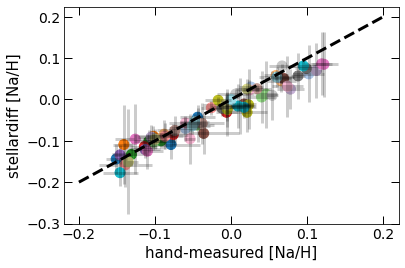

In [23]:
el = 'Na'
xmin,xmax = -0.2,0.2
plt.errorbar(expected['[{0}I]'.format(el)], sd_abund['[{0}I]'.format(el)], 
             xerr=expected['e_[{0}I]'.format(el)], yerr=sd_abund['e_[{0}I]'.format(el)], ls='', c='k', alpha=0.2)
plt.scatter(expected['[{0}I]'.format(el)], sd_abund['[{0}I]'.format(el)], 
            c=np.arange(len(expected)), cmap='tab20', alpha=1)
plt.plot([xmin,xmax], [xmin,xmax], c='k', ls='--')
plt.xlabel('hand-measured [{0}/H]'.format(el))
plt.ylabel('stellardiff [{0}/H]'.format(el))
plt.savefig(DATA_DIR+'{0}_abund_comparison.png'.format(el));

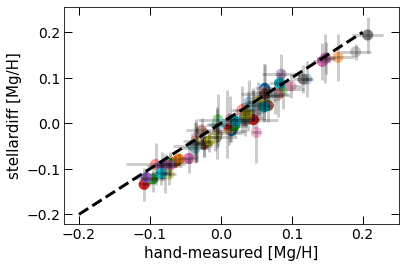

In [20]:
el = 'Mg'
xmin,xmax = -0.2,0.2
plt.errorbar(expected['[{0}I]'.format(el)], sd_abund['[{0}I]'.format(el)], 
             xerr=expected['e_[{0}I]'.format(el)], yerr=sd_abund['e_[{0}I]'.format(el)], ls='', c='k', alpha=0.2)
plt.scatter(expected['[{0}I]'.format(el)], sd_abund['[{0}I]'.format(el)], 
            c=np.arange(len(expected)), cmap='tab20', alpha=1)
plt.plot([xmin,xmax], [xmin,xmax], c='k', ls='--')
plt.xlabel('hand-measured [{0}/H]'.format(el))
plt.ylabel('stellardiff [{0}/H]'.format(el))
plt.savefig(DATA_DIR+'{0}_abund_comparison.png'.format(el));

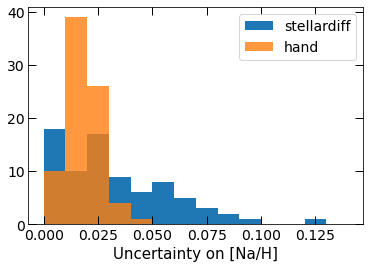

In [21]:
el = 'Na'
plt.hist(sd_abund['e_[{0}I]'.format(el)], bins=np.arange(0,0.15,0.01), label='stellardiff')
plt.hist(expected['e_[{0}I]'.format(el)], bins=np.arange(0,0.15,0.01), alpha=0.8, label='hand')
plt.legend()
plt.xlabel('Uncertainty on [{0}/H]'.format(el))
plt.savefig(DATA_DIR+'{0}_err_comparison.png'.format(el));

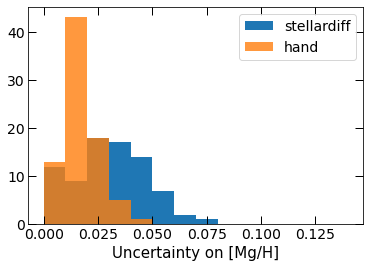

In [22]:
el = 'Mg'
plt.hist(sd_abund['e_[{0}I]'.format(el)], bins=np.arange(0,0.15,0.01), label='stellardiff')
plt.hist(expected['e_[{0}I]'.format(el)], bins=np.arange(0,0.15,0.01), alpha=0.8, label='hand')
plt.legend()
plt.xlabel('Uncertainty on [{0}/H]'.format(el))
plt.savefig(DATA_DIR+'{0}_err_comparison.png'.format(el));